In [1]:
import parsers
import pipeline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

## Preparation for the demo

In [2]:
pid_oid = pd.read_csv('link.csv')

In [3]:
pid_oid

,patient_id,original_id
0,SCD0000101,SC-HF-I-1
1,SCD0000201,SC-HF-I-2
2,SCD0000301,SC-HF-I-4
3,SCD0000401,SC-HF-I-5
4,SCD0000501,SC-HF-I-6


## API for Parsing DICOM Image

In [4]:
pid = pid_oid['patient_id'][0]
dicom_fid = 59

In [5]:
dicom_parser = parsers.DicomParser(pid, dicom_fid)
dicom_image = dicom_parser.parse()

In [6]:
print(type(dicom_image))
print(dicom_image.shape)

<type 'numpy.ndarray'>
(256, 256)


## API for Parsing Contour Files - use i-contour as an example

In [7]:
oid = pid_oid['original_id'][0]
contour_fid = 59
contour_type = 'i'

In [8]:
contour_parser = parsers.ContourParser(oid, contour_fid, contour_type)
contour_polygon = contour_parser.parse()

In [9]:
print(type(contour_polygon))
print(contour_polygon[0])

<type 'list'>
(130.5, 118.0)


## API for Parsing Boolean Mask

In [10]:
mask_parser = parsers.MaskParser(dicom_image, contour_polygon)
bool_mask = mask_parser.parse()

In [11]:
print(type(bool_mask))
print(bool_mask.shape)

<type 'numpy.ndarray'>
(256, 256)


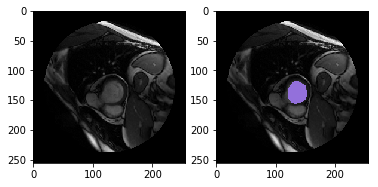

In [12]:
mask_parser.visualize()

**How to verify the correctness in the parsing of DICOM image, contour, and boolean mask?**

The verification of the correctness in parsing is done through a few different methods and aspects:
    - The correct matching of data file naming system. This part requires human carefulness in transporting the data, meticulousness in coding and good programming practices (such as avoid hard-coding filenames as much as possible). To enhance this, unit tests are added to strengthen a correct matching between DICOM image and contour files.
    - Rely on visualization and domain experties. Therefore, a `visualize` API is provided in the `MaskParser` to help engage human level examination and sanity check on the data.
    
**What changes are made on top of the initial `parsing.py` file?**

The functions for parsing DICOM image, contour files, and boolean mask are used to form a uniform `Parser` framework, where the parsing function serves as the pillar of the parsing action in each corresponding `Parser` class. Please seek more detail directly in the `parsers.py` file.

## API for A Training Pipeline

### Pairing DICOM images with contour files, load all data, parse boolean masks

In [13]:
link_fn = 'link.csv'
contour_type = 'i'
batch_size = 8

In [14]:
train_pipe = pipeline.TrainingPipeline(link_fn, contour_type, batch_size)
print(train_pipe._inputs is None, train_pipe._targets is None)

(True, True)


Preparing training data...


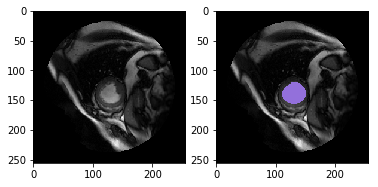

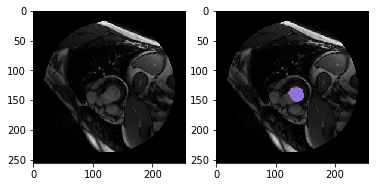

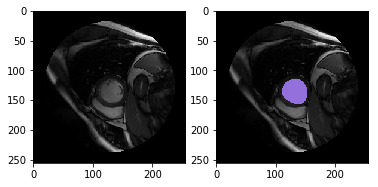

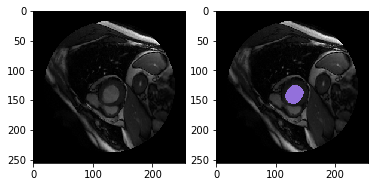

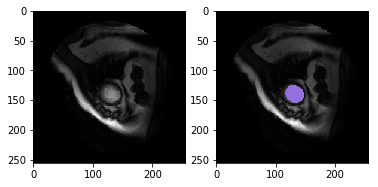

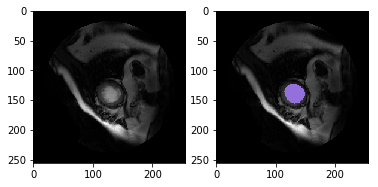

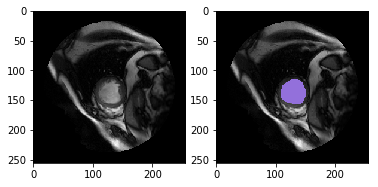

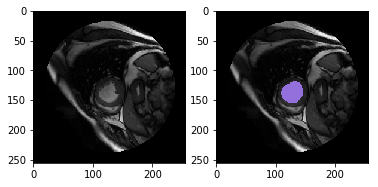

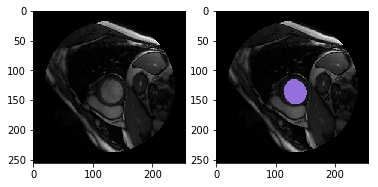

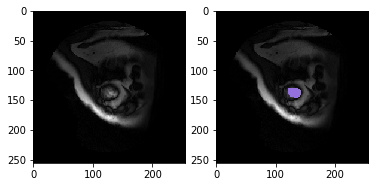

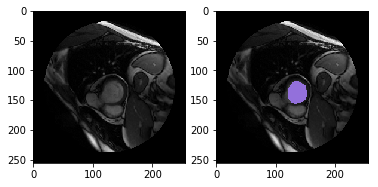

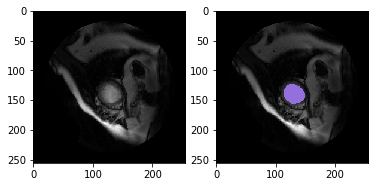

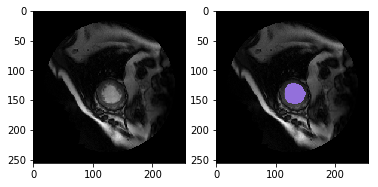

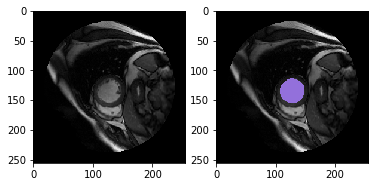

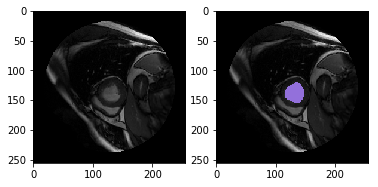

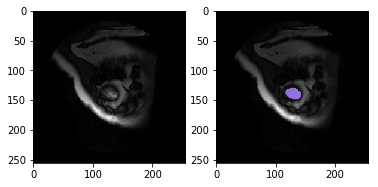

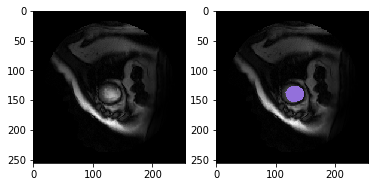

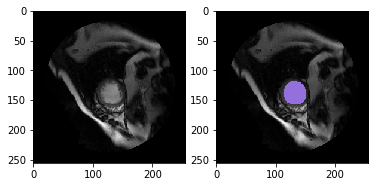

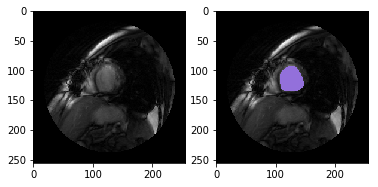

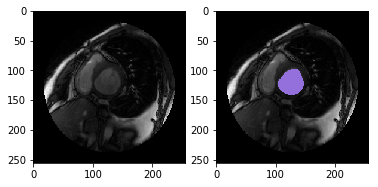

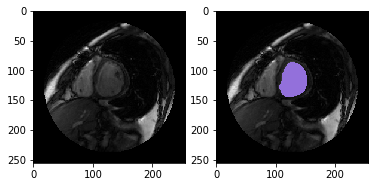

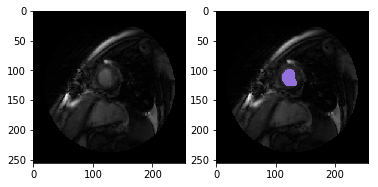

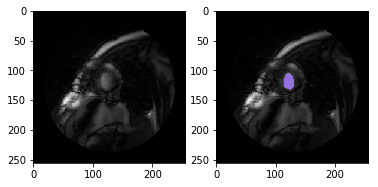

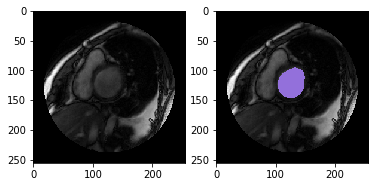

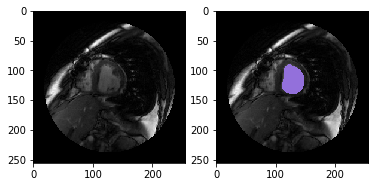

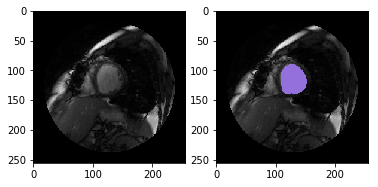

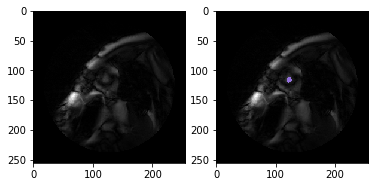

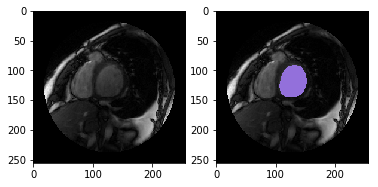

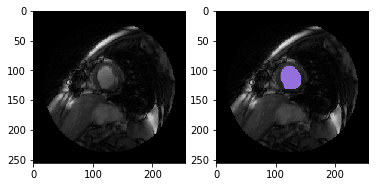

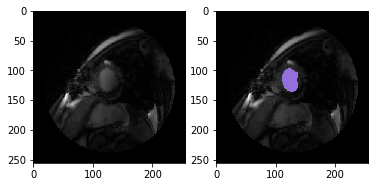

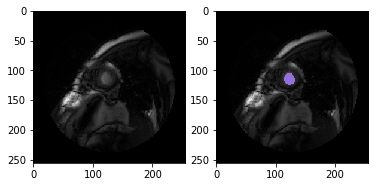

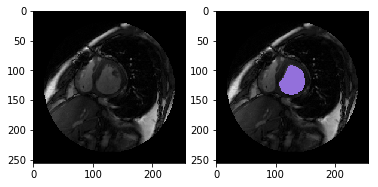

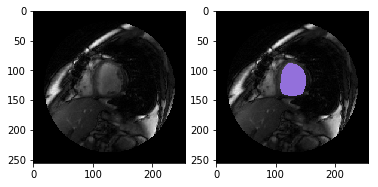

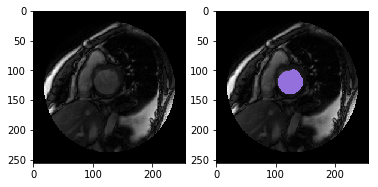

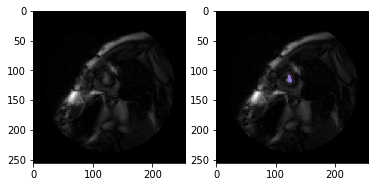

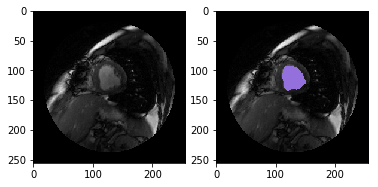

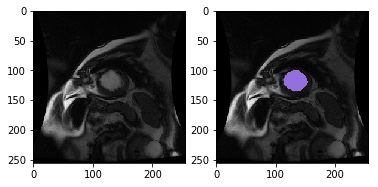

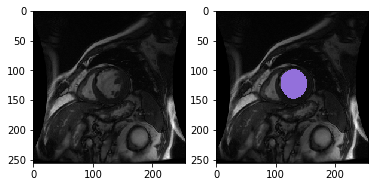

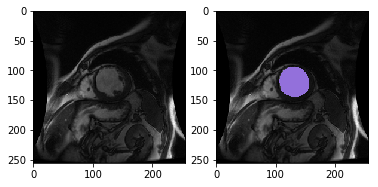

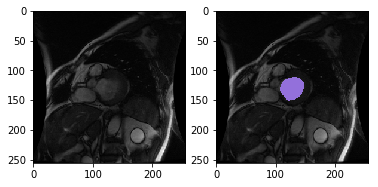

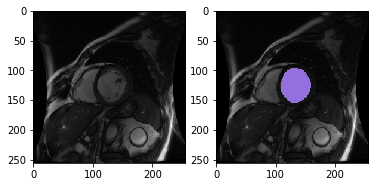

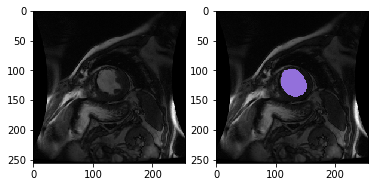

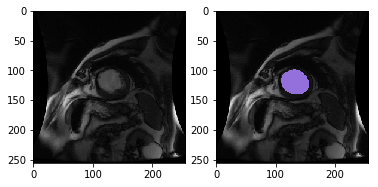

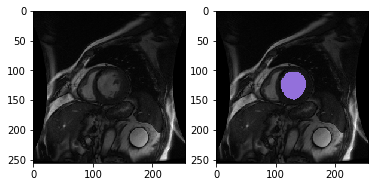

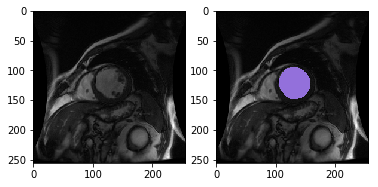

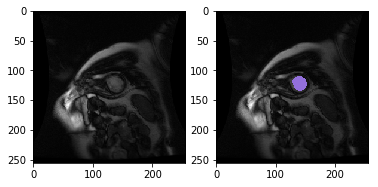

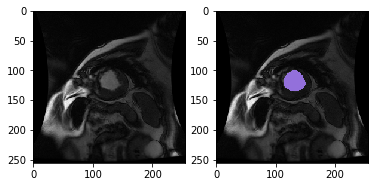

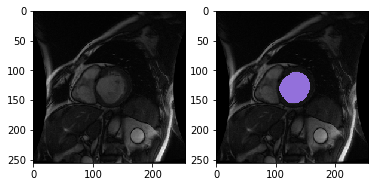

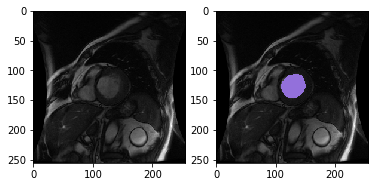

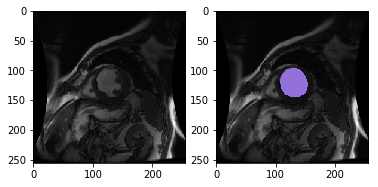

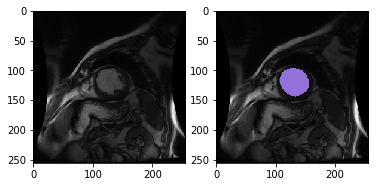

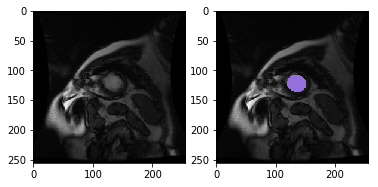

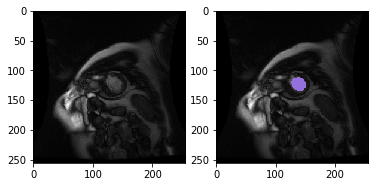

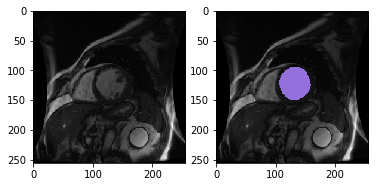

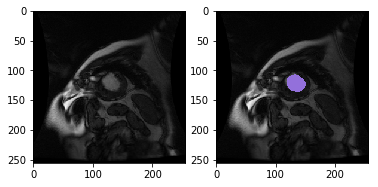

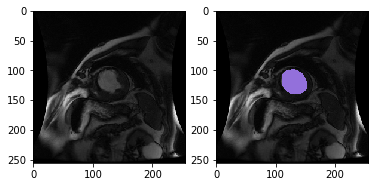

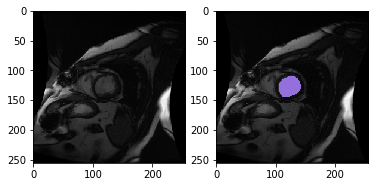

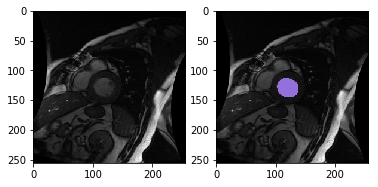

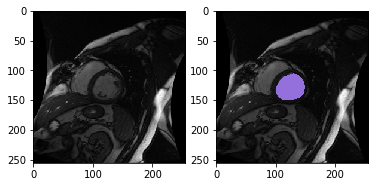

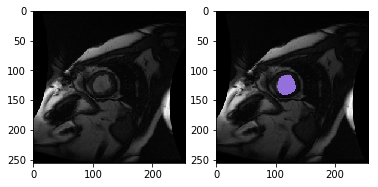

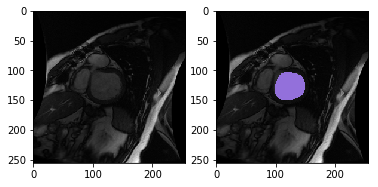

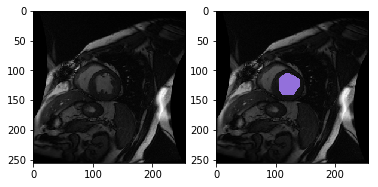

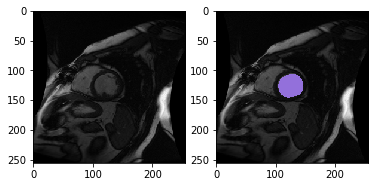

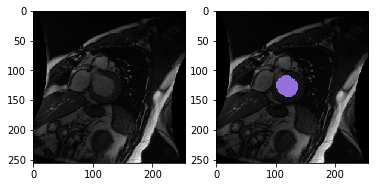

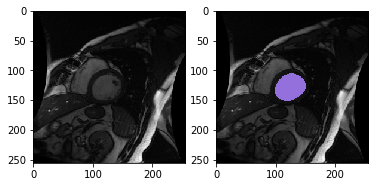

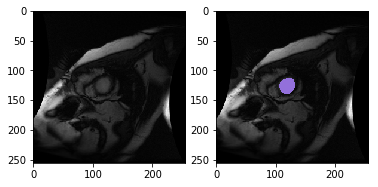

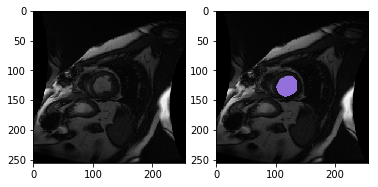

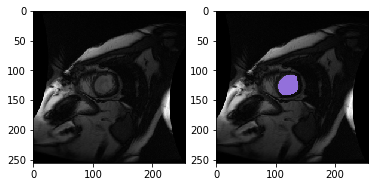

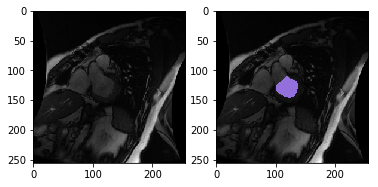

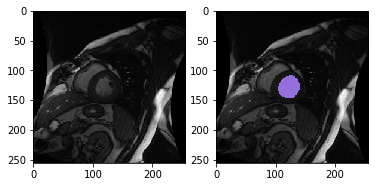

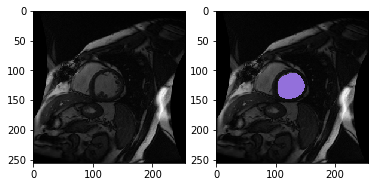

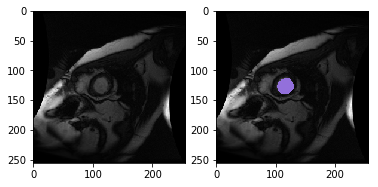

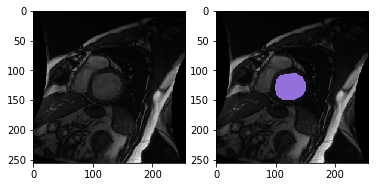

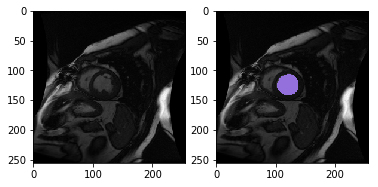

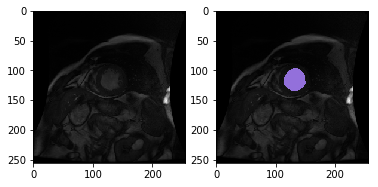

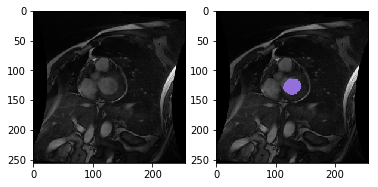

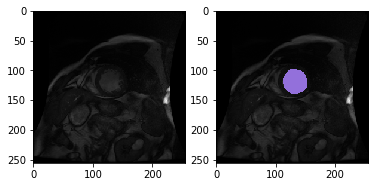

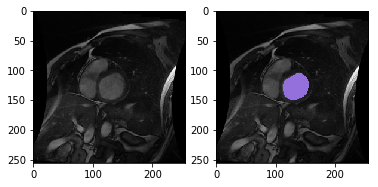

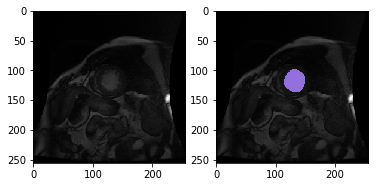

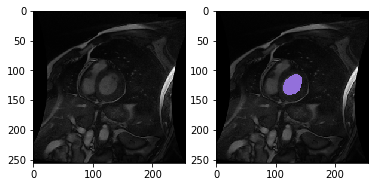

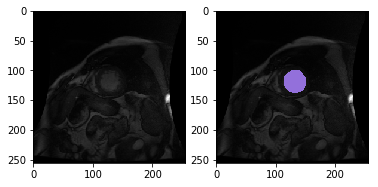

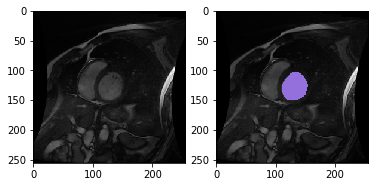

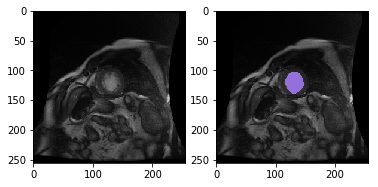

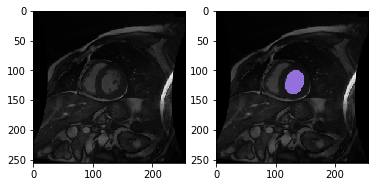

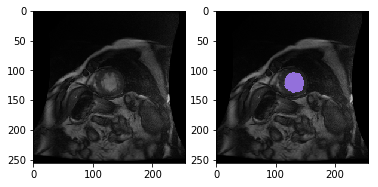

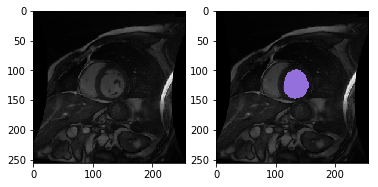

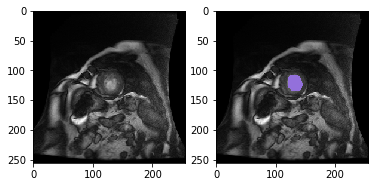

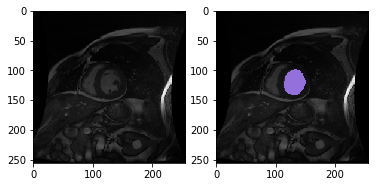

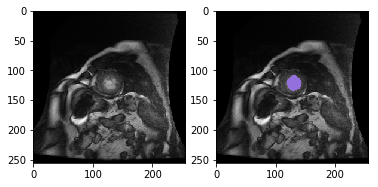

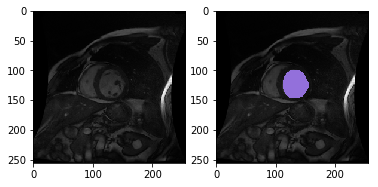

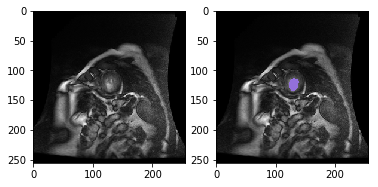

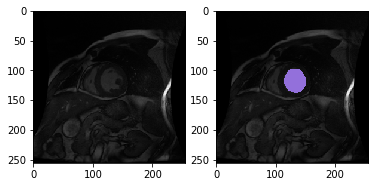

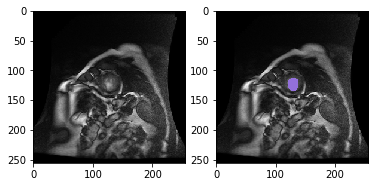

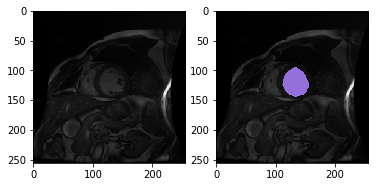

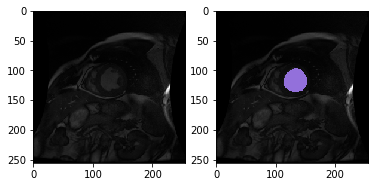

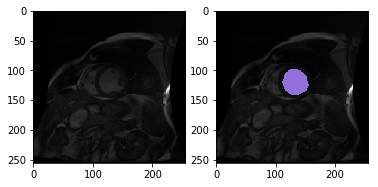

(False, False)


In [15]:
train_pipe.prepare_training_data(True)
print(train_pipe._inputs is None, train_pipe._targets is None)

In [16]:
print('number of inputs: %d \t number of targets: %d' % (len(train_pipe._inputs), len(train_pipe._targets)))

number of inputs: 96 	 number of targets: 96


### Batch serving `(input, target)` pairs 

In [17]:
num_training_steps = 20
for i in range(num_training_steps):
    batch_input, batch_target = train_pipe.next_batch()
    print('training step: %d \t batch size: %d' %(i, len(batch_input)))

training step: 0 	 batch size: 8
training step: 1 	 batch size: 8
training step: 2 	 batch size: 8
training step: 3 	 batch size: 8
training step: 4 	 batch size: 8
training step: 5 	 batch size: 8
training step: 6 	 batch size: 8
training step: 7 	 batch size: 8
training step: 8 	 batch size: 8
training step: 9 	 batch size: 8
training step: 10 	 batch size: 8
Finished iterating one epoch, reshuffling...
training step: 11 	 batch size: 8
training step: 12 	 batch size: 8
training step: 13 	 batch size: 8
training step: 14 	 batch size: 8
training step: 15 	 batch size: 8
training step: 16 	 batch size: 8
training step: 17 	 batch size: 8
training step: 18 	 batch size: 8
training step: 19 	 batch size: 8


**What changes in the `parsers.py` could be made to help better streaming data in the `TrainingPipeline`?**

Currently, all the `parsers` operate in a single input instance. It is possible to enhance the `parsers` and make them process a batch of inputs instead of a single one, which may help better streaming data for the entire pipeline.

**How is the pipeline being verified?**

Besides some basic unit tests provided in `test_pipeline.py`, the correctness of the pipleline is also examined by actually running it on IPython shell with human sanity examination. For instance, during the code development process, the looping index was printed out for verification of the correct batch iteration; the number of times where data random shuffling happened was also counted to ensure that the data shuffling happens after batch serving of one epoch.

**Propose some future potential improvements in the pipeline**

- Turn the `next_batch` API into an iterator fashion would be neater
- Build in some kind of visualization API into the pipeline would be helpful for debugging
- Have a standardized class for wrapping the `inputs` and `targets` would be neater and beneficial for other downstream operations 